In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import seaborn as sns

In [2]:
import radia as rad

In [3]:
import logging
import optid
optid.utils.logging.attach_console_logger(log_level=logging.INFO)

from optid.constants import VECTOR_ZERO, VECTOR_S, VECTOR_Z, MATRIX_ROTS_180
from optid.geometry import ChamferedCuboid, Cuboid
from optid.device   import HybridDevice, ElementSet

In [4]:
def plot_bfield_device(device, pose, bfield):
    
    plt.figure(figsize=(32, 18), facecolor='w')
    
    grid = bfield.lattice.world_lattice[0]
    bfield_filtered = np.array(bfield.field[0])
    bfield_norm = np.linalg.norm(bfield_filtered, axis=-1)
    
    
    minvec = 0.5
    mask = bfield_norm < minvec
    bfield_filtered[mask,:] = (bfield_filtered[mask,:] / bfield_norm[mask, np.newaxis]) * minvec
        
    plt.axis('off')

    plt.xlabel('S')
    plt.ylabel('Z')
    plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
    plt.ylim([grid[..., 1].min(), grid[..., 1].max()])

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        name = 'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval)
        new_cmap = colors.LinearSegmentedColormap.from_list(name, cmap(np.linspace(minval, maxval, n)))
        cm.register_cmap(name=name, cmap=new_cmap)
        return name
    
    bmin, bmax = bfield_norm.min(), bfield_norm.max()
    levels = np.linspace(bmin, bmax, 24)
    
    plt.set_cmap(truncate_colormap(plt.get_cmap('viridis'), minval=0.2, maxval=0.8, n=256))
    
    hnd = plt.contourf(grid[..., 2].transpose((1,0)), grid[..., 1].transpose((1,0)), bfield_norm.transpose((1,0)), 
                       vmin=bmin, vmax=bmax, levels=levels, alpha=0.7, zorder=0)
    
    plt.clim([bmin, bmax])

    s_skip = 2
    z_skip = 1
    plt.quiver(grid[::s_skip, ::z_skip, 2].transpose((1,0)), grid[::s_skip, ::z_skip, 1].transpose((1,0)), 
               bfield_filtered[::s_skip, ::z_skip, 2].transpose((1,0)), bfield_filtered[::s_skip, ::z_skip, 1].transpose((1,0)), color='w', alpha=0.7, scale=125, 
               minshaft=2, minlength=0.001, headwidth=6, headlength=5, headaxislength=5, width=0.1, pivot='middle', zorder=2)
        
    plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)
    
    for girder in device.girders.values():
        for slot in girder.slots:
            if True or slot.slot_type.element_set.is_magnetized:
                
                geometry, vector = slot.to_world_geometry(vector=slot.slot_type.element_set.vector, pose=pose, world_vector=False)
                
                for faces in geometry.polyhedra:
                    for face in faces:
                        plt.plot(*np.stack([geometry.vertices[vertex, [2, 1]] for vertex in (face + face[:1])], axis=0).T, c='w', linewidth=2)
                
        
    plt.tight_layout()
    plt.show()

In [5]:
def plot_bfield(bfield):
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 6), facecolor='w', dpi=100)
    plt.suptitle('B field')
    
    grid = bfield.lattice.world_lattice[0]
    bfield_filtered = np.array(bfield.field[0])
    
    for cidx, (channel, color) in enumerate(zip('XZS', 'rgb')):
        plt.sca(ax[cidx])
        plt.xlabel('S')
        plt.ylabel(channel)
        plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
        
        lim = max(abs(bfield.field[0,0,:,cidx].min()), abs(bfield.field[0,0,:,cidx].max())) * 1.1
        plt.ylim([-lim, lim])
        plt.grid('on')

        plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

        sns.lineplot(x=bfield.lattice.world_lattice[0,0,:,2], y=bfield.field[0,0,:,cidx], color=color)            
        
    plt.tight_layout()
    plt.show()

In [6]:
def plot_bfield_traj(bfield):
    
    # TODO move ring energy into device JSON file as devices are tied to specific facilities
    energy             = 3.0                           # Diamond synchrotron 3 GeV storage ring
    const              = (0.03 / energy) * 1e-2        # Unknown constant... evaluates to 1e-4 for 3 GeV storage ring
    electron_mass      = 0.511e-3                      # Electron resting mass (already in GeV for convenience)
    gamma_sq           = (energy / electron_mass) ** 2 # Ratio of energy of electron to its resting mass
    two_speed_of_light = 2.9911124e8 * 2               # Speed of light in metres per second
    degrees_per_radian = 360.0 / (2.0 * np.pi)

    s_step_size        = bfield.lattice.step[2]
    
    # bfield.shape == (eval_x, eval_z, eval_s, 3) where 3 refers to slices for the X, Z, and S field strength measurements
    # We only care about integrals of motion in X and Z so discard S measurements below

    # Trapezium rule applied to bfield measurements in X and Z helps compute the second integral of motion
    # TODO roll is on X axis (0) between neighbouring eval points, is this correct? Should be S axis (2)?
    trap_bfield = np.roll(bfield.field[...,:2], shift=1, axis=0)
    trap_bfield[...,0,:] = 0 # Set first samples on S axis to 0
    trap_bfield = (trap_bfield + bfield.field[...,:2]) * (s_step_size / 2)

    # Accumulate the second integral of motion w.r.t the X and Z axes, along the orbital S axis
    traj_2nd_integral = np.cumsum((trap_bfield * const), axis=2)

    # Trapezium rule applied to second integral of motion helps compute the first integral of motion
    # TODO why shift by 4 indices? One period? (no guarantees on how many world space units 4 indices corresponds to) Should this be 1?
    # TODO roll is on X axis (0) between neighbouring eval points, is this correct? Should be S axis (2)?
    trap_traj_2nd_integral = np.roll(traj_2nd_integral, shift=4, axis=0)
    trap_traj_2nd_integral[:,:,0,:] = 0 # Set first samples on S axis to 0
    trap_traj_2nd_integral = (trap_traj_2nd_integral + traj_2nd_integral) * (s_step_size / 2)

    # Accumulate the first integral of motion w.r.t the X and Z axes, along the orbital S axis
    traj_1st_integral = np.cumsum(trap_traj_2nd_integral, axis=2)

    # Trajectory first and second integrals of motion have been computed, now we compute the phase error of those trajectories
    # TODO why do we swap X,Z for Z,X order for the field measurements?
    #      Consistent Z,X ordering across all expected files for tests but no actual reason other than that they were all computed with this.
    #      Removal of swap forces careful conversion of expected data files.
    #      Same goes for removing Z integral negation.
    trajectories = np.concatenate([traj_1st_integral[...,::-1], traj_2nd_integral[...,::-1]], axis=-1) * np.array([-1, 1, -1, 1])
    
    fig, ax = plt.subplots(4, 1, figsize=(12, 8), facecolor='w', dpi=100)
    plt.suptitle('Trajectories')
    
    grid = bfield.lattice.world_lattice[0]
    bfield_filtered = np.array(bfield.field[0])
    
    for cidx, (order, channel, color) in enumerate(zip(['1st', '1st', '2nd', '2nd'], 'XZXZ', 'rgrg')):
        plt.sca(ax[cidx])
        plt.xlabel('S')
        plt.ylabel(channel)
        plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
        lim = max(abs(trajectories[0,0,:,cidx].min()), abs(trajectories[0,0,:,cidx].max())) * 1.1
        plt.ylim([-lim, lim])
        plt.grid('on')

        plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

        sns.lineplot(x=bfield.lattice.world_lattice[0,0,:,2], y=trajectories[0,0,:,cidx], color=color, label=f'{channel} {order}')            
        
    plt.tight_layout()
    plt.show()

### Plot B field as contour map

In [7]:
tetgen_kargs = dict(subdiv=0, nobisect=True)

mat_magnet = optid.material.NamedMaterial('Sm2Co17')
mat_pole   = optid.material.NamedMaterial('Ferrite')

hh = ElementSet(name='HH', candidates='sim/HH.csv',  vector=VECTOR_S, flip_matrices=[MATRIX_ROTS_180], 
                geometry=ChamferedCuboid(shape=(50.0, 30.0, 5.77), material=mat_magnet, chamfer=5, **tetgen_kargs))

he = ElementSet(name='HE', candidates='sim/HEC.csv', vector=VECTOR_S, flip_matrices=[MATRIX_ROTS_180], 
                geometry=ChamferedCuboid(shape=(50.0, 30.0, 3.48), material=mat_magnet, chamfer=5, **tetgen_kargs))

ht = ElementSet(name='HT', candidates='sim/HTE.csv', vector=VECTOR_S, flip_matrices=[MATRIX_ROTS_180], 
                geometry=ChamferedCuboid(shape=(50.0, 30.0, 1.14), material=mat_magnet, chamfer=5, **tetgen_kargs))


pp = ElementSet(name='PP', vector=VECTOR_ZERO, geometry=Cuboid(shape=(20.0, 20.0, 2.95), material=mat_pole, **tetgen_kargs))
pt = ElementSet(name='PT', vector=VECTOR_ZERO, geometry=Cuboid(shape=(20.0, 20.0, 5.00), material=mat_pole, **tetgen_kargs))

device = HybridDevice(name='I14-CPMU', nperiod=4, symmetric=True, hh=hh, he=he, ht=ht, pp=pp, pt=pt)

print('nperiod', device.nperiod)
print('period_length', device.period_length)
print('nslot', device.nslot)
print('nslot_by_type', device.nslot_by_type)

nperiod 4
period_length 17.69000005722046
nslot 46
nslot_by_type Counter({'PP': 18, 'HH': 16, 'HT': 4, 'PT': 4, 'HE': 4})


In [8]:
pose = optid.device.Pose(gap=1, phase=0)

2022-10-21 11:56:24.638382: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(1, 100, 100, 3)


/usr/local/optid/src/optid/core/affine.py:123: RuntimeWarning: invalid value encountered in divide
  lattice = transform_vectors((lattice / norm), matrix)


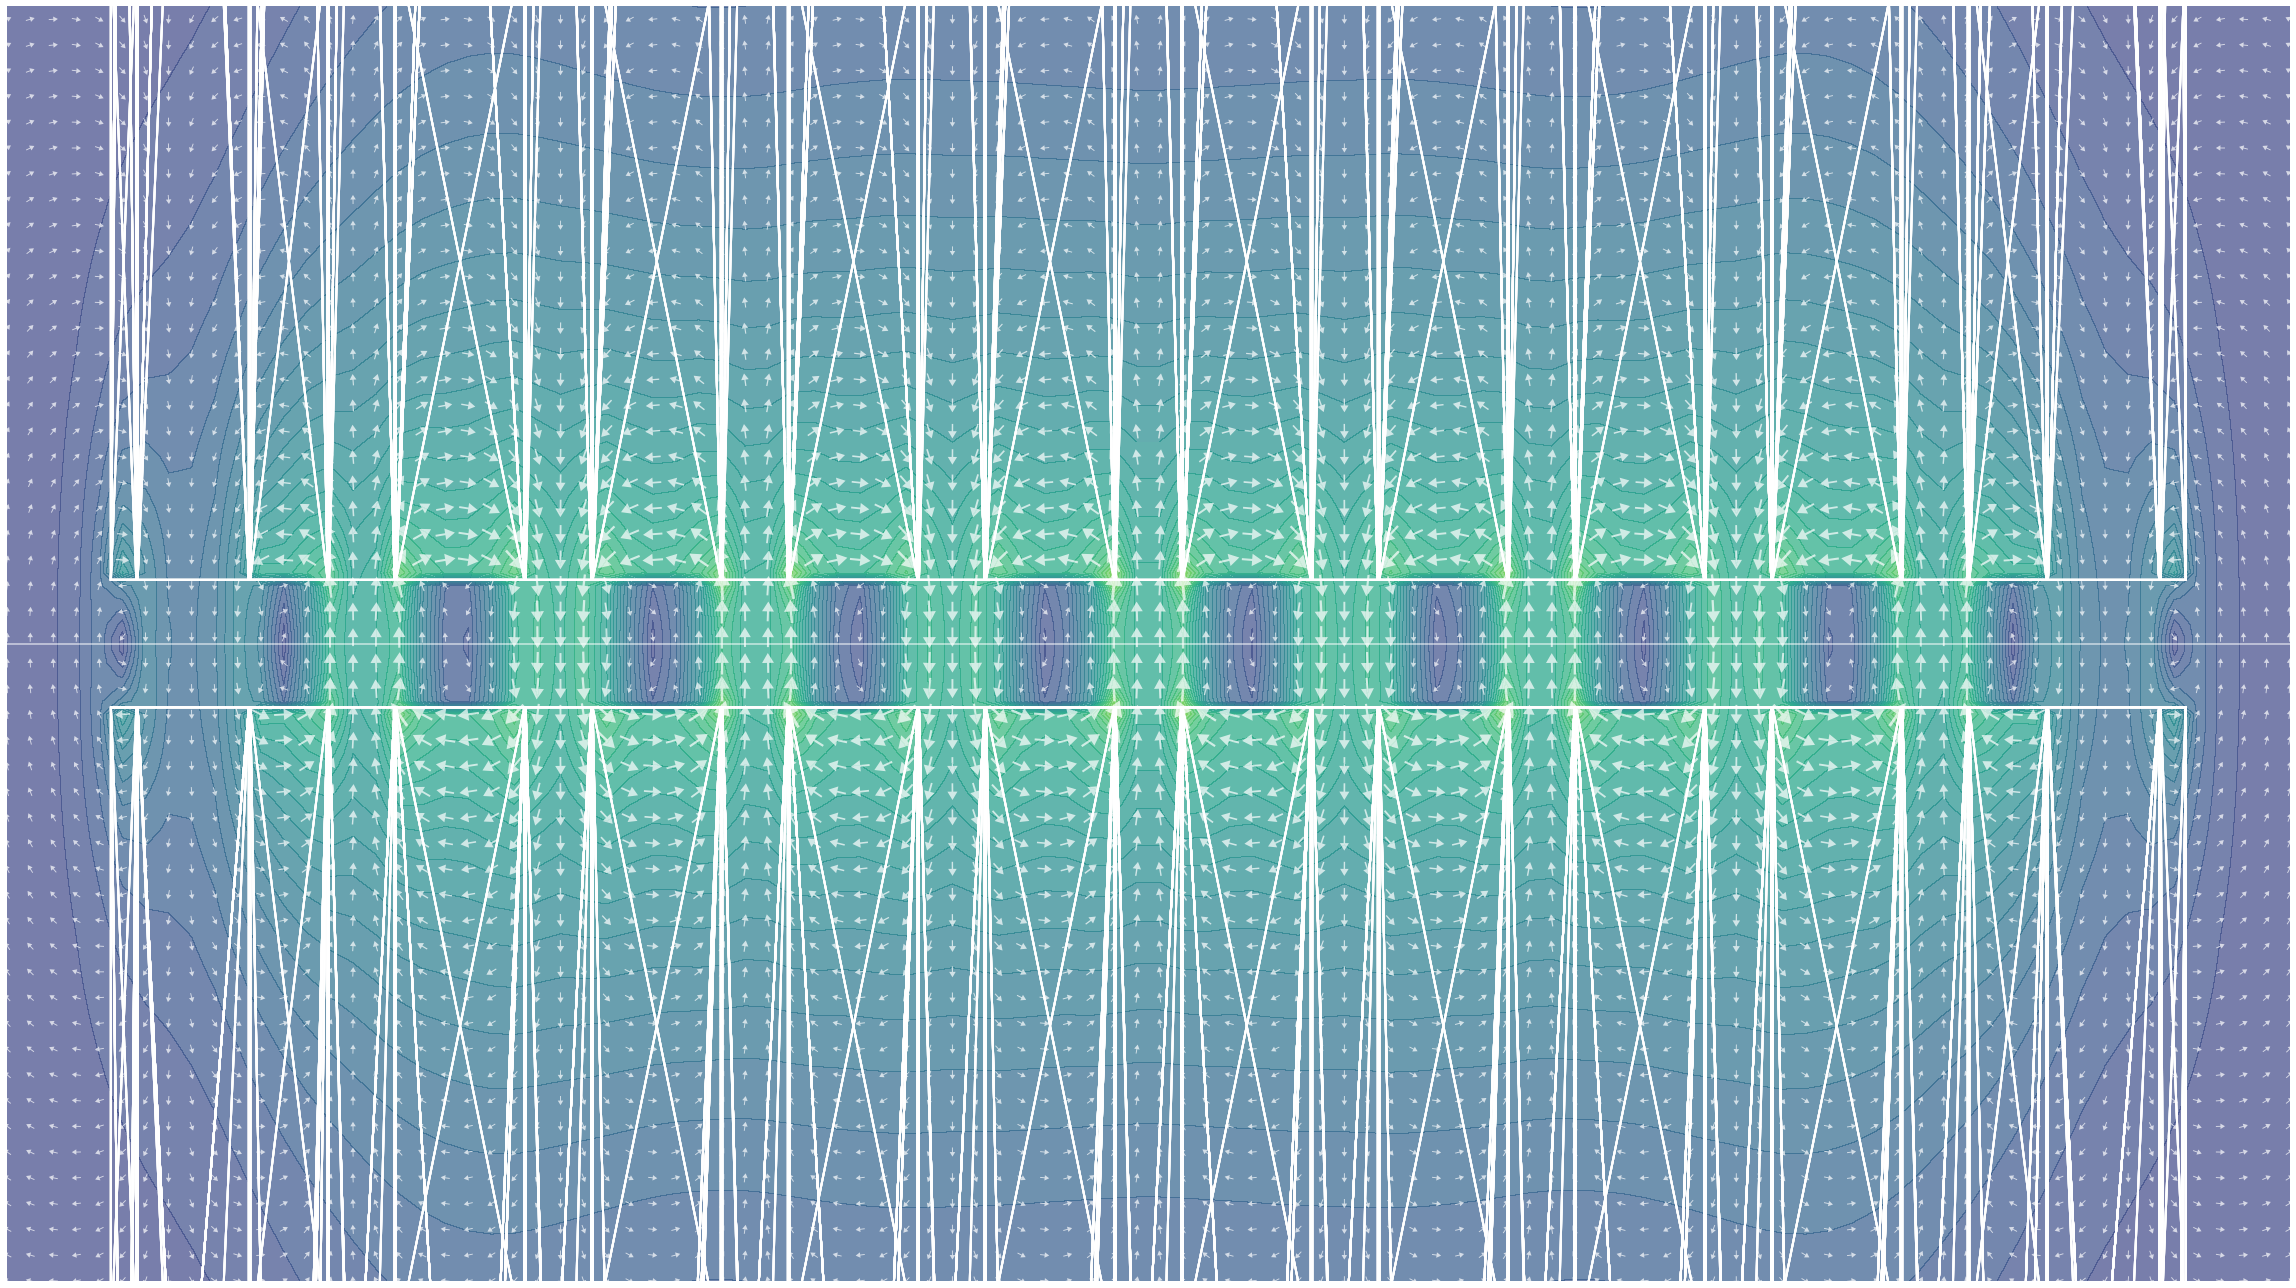

In [9]:
bfield = device.bfield(lattice=optid.lattice.Lattice(optid.core.affine.scale(1, 10, device.length * 1.1), shape=(1, 100, 100)), pose=pose)
print(bfield.field.shape)
plot_bfield_device(device, pose, bfield)

In [10]:
tetgen_kargs = dict(subdiv=0, nobisect=True)

mat_magnet = optid.material.NamedMaterial('Sm2Co17')
mat_pole = optid.material.NamedMaterial('Ferrite')
hh = ElementSet(name='HH', candidates='sim/HH.csv',  vector=VECTOR_S, flip_matrices=[MATRIX_ROTS_180], geometry=ChamferedCuboid(shape=(50.0, 30.0, 5.77), material=mat_magnet, chamfer=5, **tetgen_kargs))
he = ElementSet(name='HE', candidates='sim/HEC.csv', vector=VECTOR_S, flip_matrices=[MATRIX_ROTS_180], geometry=ChamferedCuboid(shape=(50.0, 30.0, 3.48), material=mat_magnet, chamfer=5, **tetgen_kargs))
ht = ElementSet(name='HT', candidates='sim/HTE.csv', vector=VECTOR_S, flip_matrices=[MATRIX_ROTS_180], geometry=ChamferedCuboid(shape=(50.0, 30.0, 1.14), material=mat_magnet, chamfer=5, **tetgen_kargs))
pp = ElementSet(name='PP', vector=VECTOR_ZERO, geometry=Cuboid(shape=(20.0, 20.0, 2.95), material=mat_pole, **tetgen_kargs))
pt = ElementSet(name='PT', vector=VECTOR_ZERO, geometry=Cuboid(shape=(20.0, 20.0, 5.00), material=mat_pole, **tetgen_kargs))

device = HybridDevice(name='I14-CPMU', nperiod=100, symmetric=True, hh=hh, he=he, ht=ht, pp=pp, pt=pt)

print('nperiod', device.nperiod)
print('period_length', device.period_length)
print('nslot', device.nslot)
print('nslot_by_type', device.nslot_by_type)

nperiod 100
period_length 17.69000005722046
nslot 814
nslot_by_type Counter({'PP': 402, 'HH': 400, 'HT': 4, 'PT': 4, 'HE': 4})


In [22]:
bfield = device.bfield(lattice=optid.lattice.Lattice(optid.core.affine.scale(1, 1, device.length * 1.5), shape=(1, 1, 2000)), pose=pose)
print(bfield.field.shape)

(1, 1, 2000, 3)


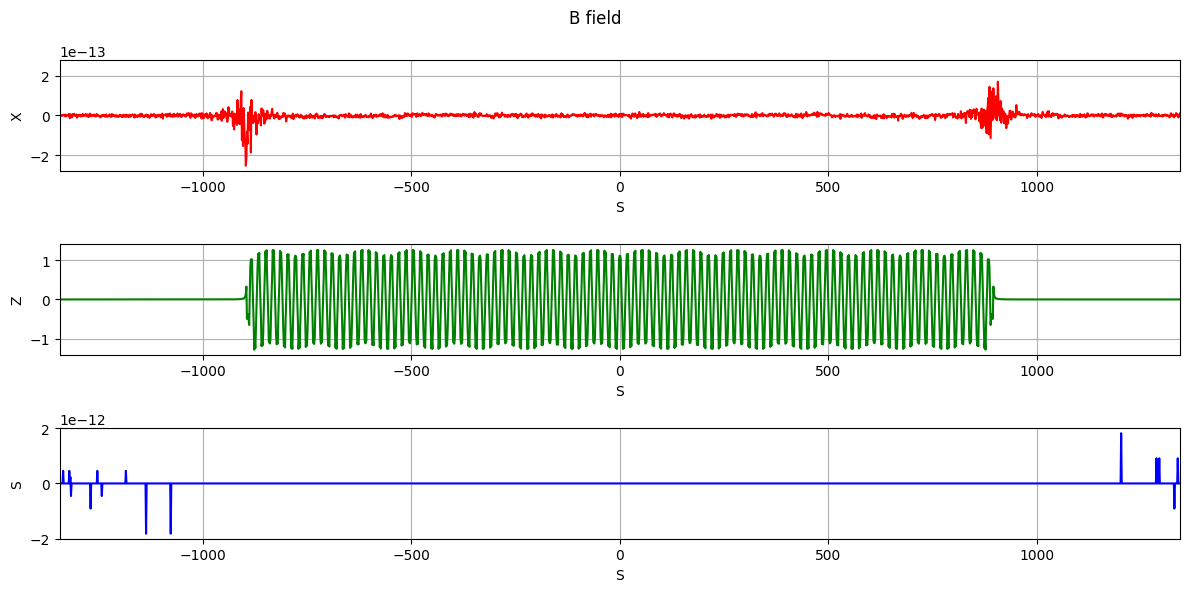

In [23]:
plot_bfield(bfield)

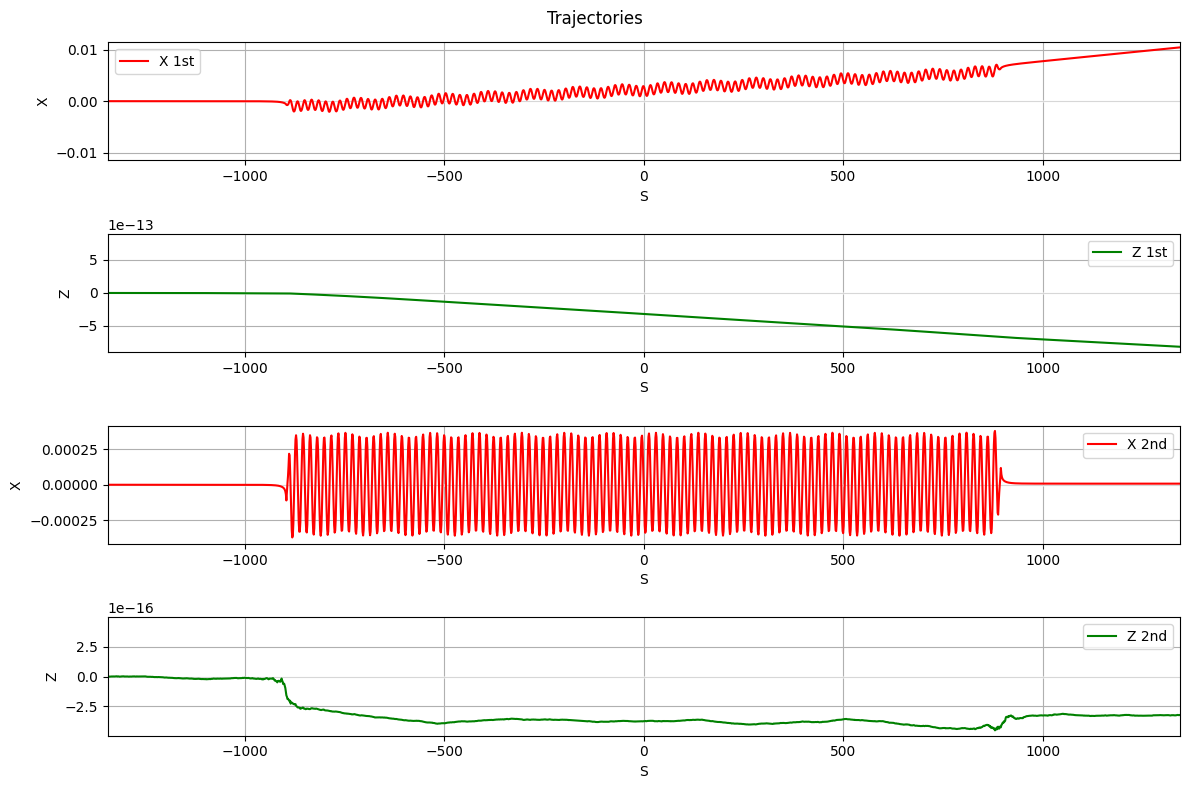

In [24]:
plot_bfield_traj(bfield)

In [56]:
bfield_error = device.bfield(lattice=optid.lattice.Lattice(optid.core.affine.scale(1, 1, device.length * 1.5), shape=(1, 1, 2000)), pose=pose, add_noise=True)
print(bfield_error.field.shape)

(1, 1, 2000, 3)


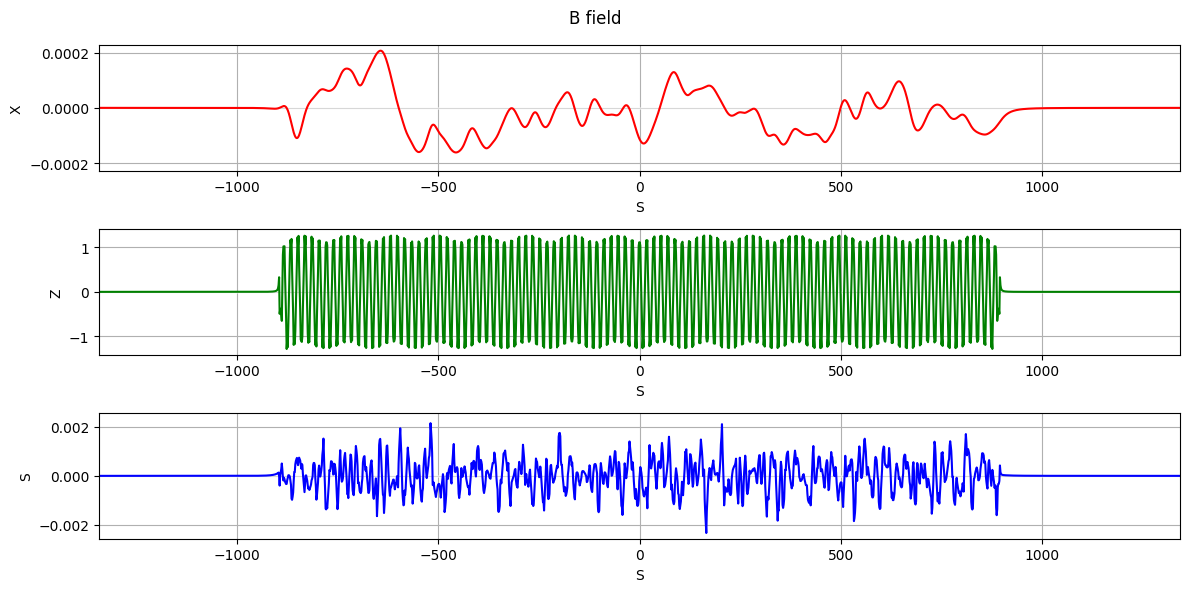

In [57]:
plot_bfield(bfield_error)

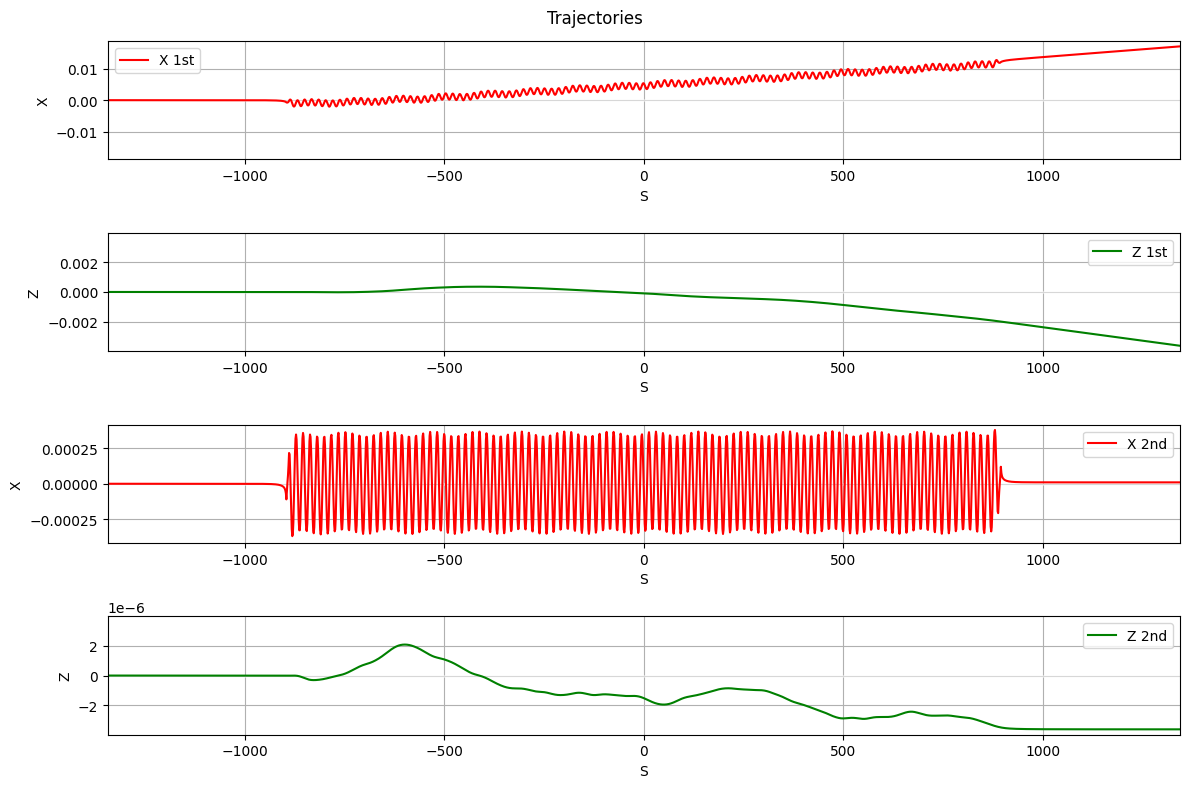

In [58]:
plot_bfield_traj(bfield_error)

In [84]:
def trajectories(bfield, energy=3.0):
    # Diamond synchrotron 3 GeV storage ring
    
    const              = (0.03 / energy) * 1e-2        # Unknown constant... evaluates to 1e-4 for 3 GeV storage ring
    electron_mass      = 0.511e-3                      # Electron resting mass (already in GeV for convenience)
    gamma_sq           = (energy / electron_mass) ** 2 # Ratio of energy of electron to its resting mass
    two_speed_of_light = 2.9911124e8 * 2               # Speed of light in metres per second
    degrees_per_radian = 360.0 / (2.0 * np.pi)

    s_step_size        = bfield.lattice.step[2]
    
    # bfield.shape == (eval_x, eval_z, eval_s, 3) where 3 refers to slices for the X, Z, and S field strength measurements
    # We only care about integrals of motion in X and Z so discard S measurements below

    # Trapezium rule applied to bfield measurements in X and Z helps compute the second integral of motion
    trap_bfield = np.roll(bfield.field[...,:2], shift=1, axis=2)
    trap_bfield[...,0,:] = 0 # Set first samples on S axis to 0
    trap_bfield = (trap_bfield + bfield.field[...,:2]) * (s_step_size / 2)

    # Accumulate the second integral of motion w.r.t the X and Z axes, along the orbital S axis
    traj_2nd_integral = np.cumsum((trap_bfield * const), axis=2)

    # Trapezium rule applied to second integral of motion helps compute the first integral of motion
    trap_traj_2nd_integral = np.roll(traj_2nd_integral, shift=1, axis=2)
    trap_traj_2nd_integral[:,:,0,:] = 0 # Set first samples on S axis to 0
    trap_traj_2nd_integral = (trap_traj_2nd_integral + traj_2nd_integral) * (s_step_size / 2)

    # Accumulate the first integral of motion w.r.t the X and Z axes, along the orbital S axis
    traj_1st_integral = np.cumsum(trap_traj_2nd_integral, axis=2)

    trajectories = np.concatenate([traj_1st_integral[...,::-1], traj_2nd_integral[...,::-1]], axis=-1) * np.array([-1, 1, -1, 1])
    
    return trajectories

In [85]:
def l2_loss(observed, expected):
    return jnp.mean(jnp.square(observed - expected))

In [86]:
def lobf(s, x, z):
    
    s_flat = s.flatten()
    x_flat = x.flatten()
    z_flat = z.flatten()
    
    x_fit = np.reshape(np.poly1d(np.polyfit(s_flat, x_flat, 1))(s_flat), x.shape)
    z_fit = np.reshape(np.poly1d(np.polyfit(s_flat, z_flat, 1))(s_flat), z.shape)
    
    return x_fit, z_fit

In [87]:
def trajectory_lobf(bfield, trajectories):
    
    coords = bfield.lattice.world_lattice
    
    s_coords = coords[..., 2]
    x1_traj = trajectories[..., 0]
    z1_traj = trajectories[..., 1]
    
    x1_fit, z1_fit = lobf(s_coords, x1_traj, z1_traj)
    
    return jnp.stack([x1_fit, z1_fit], axis=-1)
    
traj      = trajectories(bfield)
traj_fit  = trajectory_lobf(bfield, traj)  
traj_norm = traj[..., :2] - traj_fit

traj_error      = trajectories(bfield_error)
traj_error_fit  = trajectory_lobf(bfield_error, traj_error) 
traj_error_norm = traj_error[..., :2] - traj_error_fit

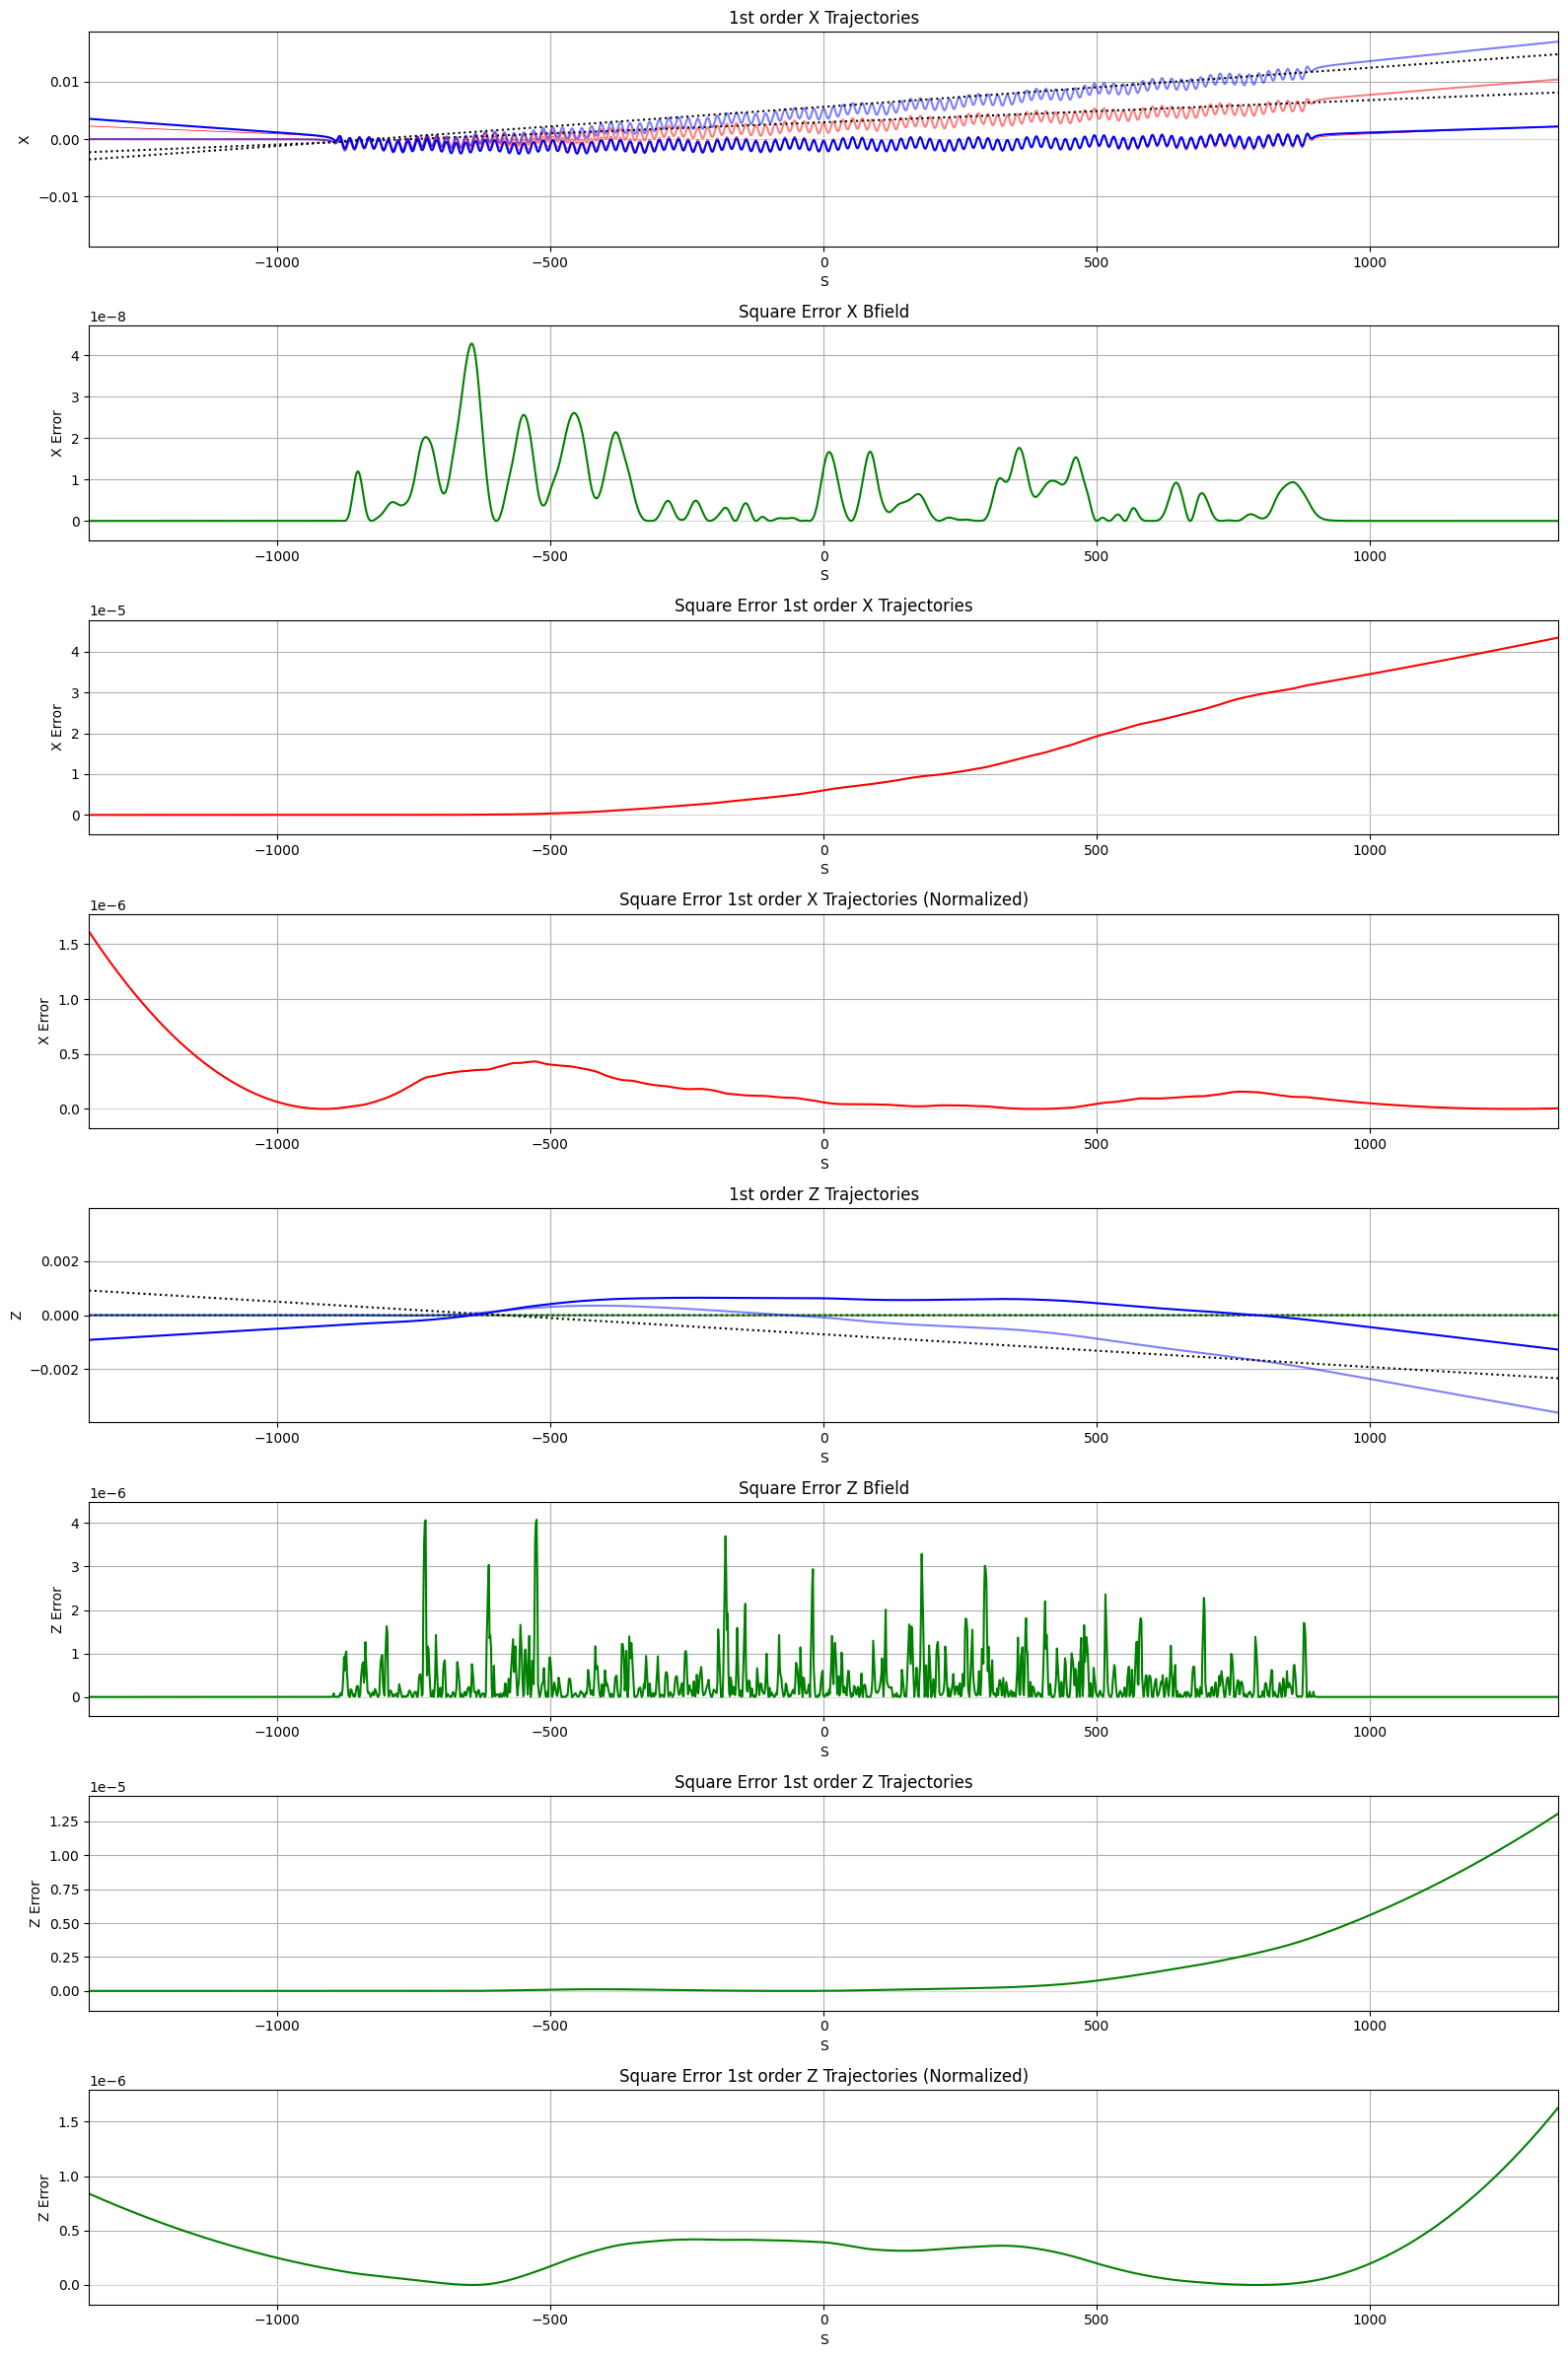

In [88]:
grid = bfield.lattice.world_lattice
    
plt.figure(figsize=(16, 24), facecolor='w', dpi=100)

plt.subplot(8, 1, 1)

plt.title('1st order X Trajectories')
plt.xlabel('S')
plt.ylabel('X')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
lim = max(abs(traj_error[0,0,:,0].min()), abs(traj_error[0,0,:,0].max())) * 1.1
plt.ylim([-lim, lim])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

sns.lineplot(x=grid[0,0,:,2], y=traj[0,0,:,0], color='r', alpha=0.5)
sns.lineplot(x=grid[0,0,:,2], y=traj_fit[0,0,:,0], linestyle=':', color='k')  
sns.lineplot(x=grid[0,0,:,2], y=traj_norm[0,0,:,0], color='r', linewidth=0.5)   

sns.lineplot(x=grid[0,0,:,2], y=traj_error[0,0,:,0], color='b', alpha=0.5)
sns.lineplot(x=grid[0,0,:,2], y=traj_error_fit[0,0,:,0], linestyle=':', color='k')  
sns.lineplot(x=grid[0,0,:,2], y=traj_error_norm[0,0,:,0], color='b')   

plt.subplot(8, 1, 2)

plt.title('Square Error X Bfield')
plt.xlabel('S')
plt.ylabel('X Error')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

l2_error = np.square(bfield.field[0,0,:,0] - bfield_error.field[0,0,:,0])
lim = max(abs(l2_error.min()), abs(l2_error.max())) * 1.1
plt.ylim([-lim*0.1, lim])

sns.lineplot(x=grid[0,0,:,2], y=l2_error, color='g')

plt.subplot(8, 1, 3)

plt.title('Square Error 1st order X Trajectories')
plt.xlabel('S')
plt.ylabel('X Error')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

l2_error = np.square(traj[0,0,:,0] - traj_error[0,0,:,0])
lim = max(abs(l2_error.min()), abs(l2_error.max())) * 1.1
plt.ylim([-lim*0.1, lim])

sns.lineplot(x=grid[0,0,:,2], y=l2_error, color='r')

plt.subplot(8, 1, 4)

plt.title('Square Error 1st order X Trajectories (Normalized)')
plt.xlabel('S')
plt.ylabel('X Error')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

l2_error = np.square(traj_norm[0,0,:,0] - traj_error_norm[0,0,:,0])
lim = max(abs(l2_error.min()), abs(l2_error.max())) * 1.1
plt.ylim([-lim*0.1, lim])

sns.lineplot(x=grid[0,0,:,2], y=l2_error, color='r')

# ---------------------------------------------------------------------------------

plt.subplot(8, 1, 5)

plt.title('1st order Z Trajectories')
plt.xlabel('S')
plt.ylabel('Z')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
lim = max(abs(traj_error[0,0,:,1].min()), abs(traj_error[0,0,:,1].max())) * 1.1
plt.ylim([-lim, lim])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

sns.lineplot(x=grid[0,0,:,2], y=traj[0,0,:,1], color='g', alpha=0.5)
sns.lineplot(x=grid[0,0,:,2], y=traj_fit[0,0,:,1], linestyle=':', color='k')  
sns.lineplot(x=grid[0,0,:,2], y=traj_norm[0,0,:,1], color='g', linewidth=0.5) 

sns.lineplot(x=grid[0,0,:,2], y=traj_error[0,0,:,1], color='b', alpha=0.5)
sns.lineplot(x=grid[0,0,:,2], y=traj_error_fit[0,0,:,1], linestyle=':', color='k')  
sns.lineplot(x=grid[0,0,:,2], y=traj_error_norm[0,0,:,1], color='b') 

plt.subplot(8, 1, 6)

plt.title('Square Error Z Bfield')
plt.xlabel('S')
plt.ylabel('Z Error')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

l2_error = np.square(bfield.field[0,0,:,1] - bfield_error.field[0,0,:,1])
lim = max(abs(l2_error.min()), abs(l2_error.max())) * 1.1
plt.ylim([-lim*0.1, lim])

sns.lineplot(x=grid[0,0,:,2], y=l2_error, color='g')

plt.subplot(8, 1, 7)

plt.title('Square Error 1st order Z Trajectories')
plt.xlabel('S')
plt.ylabel('Z Error')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

l2_error = np.square(traj[0,0,:,1] - traj_error[0,0,:,1])
lim = max(abs(l2_error.min()), abs(l2_error.max())) * 1.1
plt.ylim([-lim*0.1, lim])

sns.lineplot(x=grid[0,0,:,2], y=l2_error, color='g')

plt.subplot(8, 1, 8)

plt.title('Square Error 1st order Z Trajectories (Normalized)')
plt.xlabel('S')
plt.ylabel('Z Error')
plt.xlim([grid[..., 2].min(), grid[..., 2].max()])
plt.grid('on')

plt.axhline(linestyle='-', color='w', linewidth=2, alpha=0.5)

l2_error = np.square(traj_norm[0,0,:,1] - traj_error_norm[0,0,:,1])
lim = max(abs(l2_error.min()), abs(l2_error.max())) * 1.1
plt.ylim([-lim*0.1, lim])

sns.lineplot(x=grid[0,0,:,2], y=l2_error, color='g')

plt.tight_layout()
plt.show()